# SARIMA model

## Load dependencies and data, create folds

In [1]:
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults

import warnings
warnings.filterwarnings("ignore")

In [2]:
arima_df = pd.read_csv('trainvalidtest_dummy.csv')
arima_df = arima_df.iloc[:, :3]
arima_df

,Year,Quarter,NCN_sales_est
0,2008,1,40446.0
1,2008,2,54576.0
2,2008,3,54635.0
3,2008,4,48859.0
4,2009,1,31236.0
...,...,...,...
59,2022,4,79376.0
60,2023,1,46742.0
61,2023,2,76021.0
62,2023,3,75548.0


In [3]:
# Combine "Year" and "Quarter" columns into a single datetime index
arima_df['End_of_Quarter'] = pd.PeriodIndex(arima_df['Year'].astype(str) + 'Q' + arima_df['Quarter'].astype(str), freq='Q').to_timestamp()
# Adjust to represent the end date of each quarter
arima_df['End_of_Quarter'] = arima_df['End_of_Quarter'] + pd.offsets.MonthEnd(3)
arima_df.drop(columns=['Year', 'Quarter'], inplace=True)

# Set the datetime index
arima_df.set_index('End_of_Quarter', inplace=True)
arima_df

,NCN_sales_est
End_of_Quarter,
2008-03-31,40446.0
2008-06-30,54576.0
2008-09-30,54635.0
2008-12-31,48859.0
2009-03-31,31236.0
...,...
2022-12-31,79376.0
2023-03-31,46742.0
2023-06-30,76021.0


In [4]:
# Number of quarters to keep for validation
validation_quarters = 4

splits_val = {'train': [], 'val': []}

for i in range(len(arima_df)-19, len(arima_df) - validation_quarters, 1):
    train_data = arima_df.iloc[:i + validation_quarters]
    valid_data = arima_df.iloc[i + validation_quarters:i + validation_quarters + validation_quarters]
    print(f'TRAIN: {train_data.index}, VALID: {valid_data.index}')
    splits_val['train'].append(train_data)
    splits_val['val'].append(valid_data)

    if i + 11 >= len(arima_df) - 1:
        break

TRAIN: DatetimeIndex(['2008-03-31', '2008-06-30', '2008-09-30', '2008-12-31',
               '2009-03-31', '2009-06-30', '2009-09-30', '2009-12-31',
               '2010-03-31', '2010-06-30', '2010-09-30', '2010-12-31',
               '2011-03-31', '2011-06-30', '2011-09-30', '2011-12-31',
               '2012-03-31', '2012-06-30', '2012-09-30', '2012-12-31',
               '2013-03-31', '2013-06-30', '2013-09-30', '2013-12-31',
               '2014-03-31', '2014-06-30', '2014-09-30', '2014-12-31',
               '2015-03-31', '2015-06-30', '2015-09-30', '2015-12-31',
               '2016-03-31', '2016-06-30', '2016-09-30', '2016-12-31',
               '2017-03-31', '2017-06-30', '2017-09-30', '2017-12-31',
               '2018-03-31', '2018-06-30', '2018-09-30', '2018-12-31',
               '2019-03-31', '2019-06-30', '2019-09-30', '2019-12-31',
               '2020-03-31'],
              dtype='datetime64[ns]', name='End_of_Quarter', freq=None), VALID: DatetimeIndex(['2020-06-30', '2

In [5]:
# Number of quarters to keep for validation
validation_quarters = 4

splits_test = {'train': [], 'test': []}

for i in range(len(arima_df)-15, len(arima_df) - validation_quarters, 1):
    train_data = arima_df.iloc[:i + validation_quarters]
    valid_data = arima_df.iloc[i + validation_quarters:i + validation_quarters + validation_quarters]
    print(f'TRAIN: {train_data.index}, TEST: {valid_data.index}')
    splits_test['train'].append(train_data)
    splits_test['test'].append(valid_data)

    if i + 7 >= len(arima_df) - 1:
        break

TRAIN: DatetimeIndex(['2008-03-31', '2008-06-30', '2008-09-30', '2008-12-31',
               '2009-03-31', '2009-06-30', '2009-09-30', '2009-12-31',
               '2010-03-31', '2010-06-30', '2010-09-30', '2010-12-31',
               '2011-03-31', '2011-06-30', '2011-09-30', '2011-12-31',
               '2012-03-31', '2012-06-30', '2012-09-30', '2012-12-31',
               '2013-03-31', '2013-06-30', '2013-09-30', '2013-12-31',
               '2014-03-31', '2014-06-30', '2014-09-30', '2014-12-31',
               '2015-03-31', '2015-06-30', '2015-09-30', '2015-12-31',
               '2016-03-31', '2016-06-30', '2016-09-30', '2016-12-31',
               '2017-03-31', '2017-06-30', '2017-09-30', '2017-12-31',
               '2018-03-31', '2018-06-30', '2018-09-30', '2018-12-31',
               '2019-03-31', '2019-06-30', '2019-09-30', '2019-12-31',
               '2020-03-31', '2020-06-30', '2020-09-30', '2020-12-31',
               '2021-03-31'],
              dtype='datetime64[ns]', na

In [6]:
# First validation split
splits_val['val'][0]

,NCN_sales_est
End_of_Quarter,
2020-06-30,73062.0
2020-09-30,70453.0
2020-12-31,50625.0
2021-03-31,46978.0


In [7]:
# First test split
splits_test['test'][0]

,NCN_sales_est
End_of_Quarter,
2021-06-30,65862.0
2021-09-30,84815.0
2021-12-31,74396.0
2022-03-31,64830.0


## Seasonal decompose

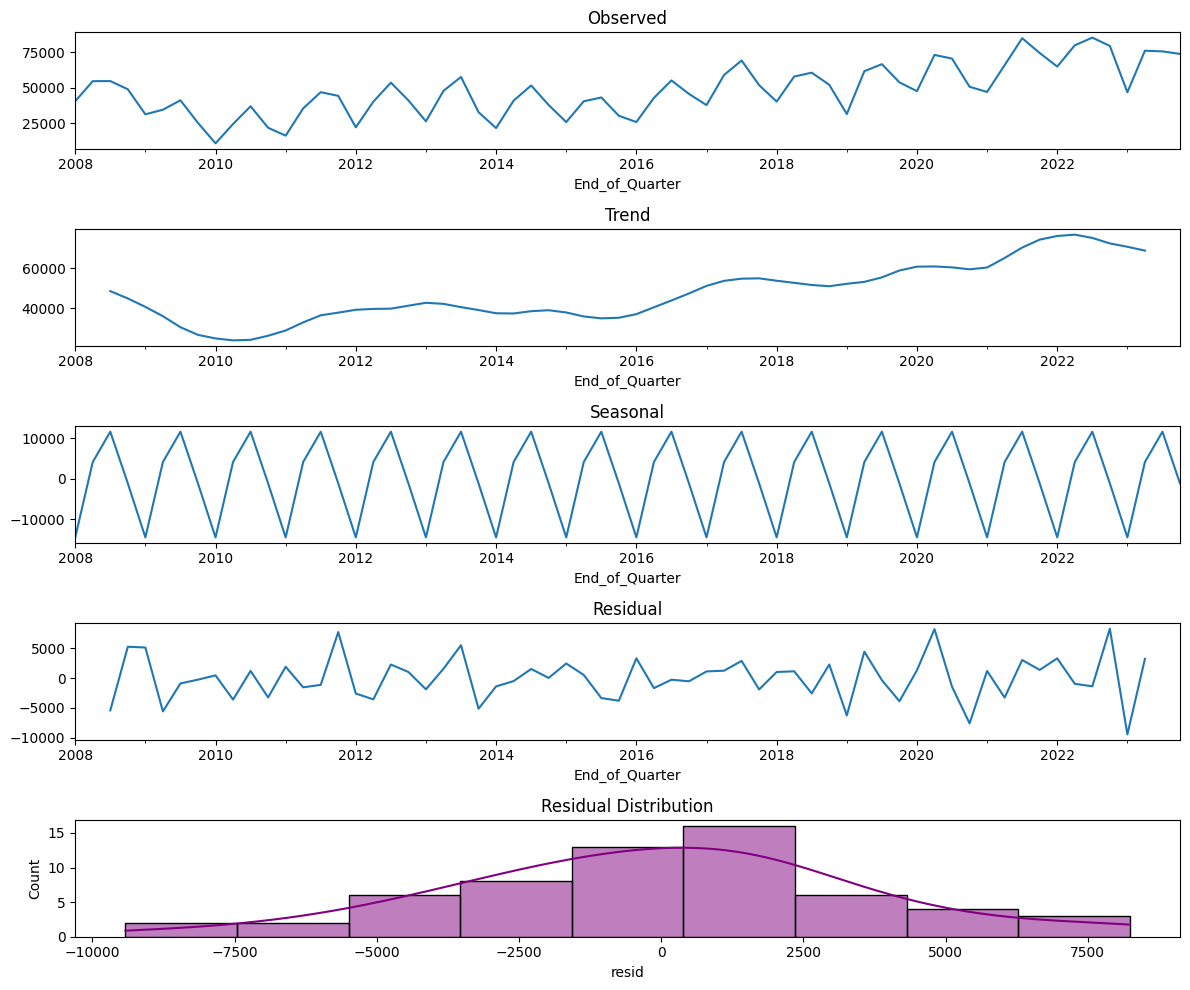

In [8]:

sd = seasonal_decompose(arima_df)
# Adjust the figure size
fig, axes = plt.subplots(5, 1, figsize=(12, 10))

# Plot the seasonal decomposition components
sd.observed.plot(ax=axes[0])
axes[0].set_title('Observed')
sd.trend.plot(ax=axes[1])
axes[1].set_title('Trend')
sd.seasonal.plot(ax=axes[2])
axes[2].set_title('Seasonal')
sd.resid.plot(ax=axes[3])
axes[3].set_title('Residual')

# Plot the distribution of residuals (histogram and KDE)
sns.histplot(sd.resid.dropna(), kde=True, ax=axes[4], color='purple')
axes[4].set_title('Residual Distribution')

plt.savefig('TSDecomp.png')
plt.savefig('TSDecomp.pdf')

# Show the plot
plt.tight_layout()
plt.show()



## SARIMA optimisation

### Validation

In [9]:
# Define the ranges for p, d, and q values
p_values = [1, 2, 3, 4, 5]
d_values = [1]
q_values = [1, 2, 3, 4, 5]
P = [1, 2, 3, 4]
D = [1]
Q = [1, 2, 3, 4]

best_mape_val = float('inf')  # Initialize best MAPE to positive infinity
best_std_val = None
best_combination = None
mape_fold_values = []  # To store MAPE values for each fold
predictions = []
actuals = []

total_iterations = len(p_values) * len(d_values) * len(q_values) * len(P) * len(D) * len(Q)
current_iteration = 0
# Iterate through different combinations of p, d, and q values
for p, d, q, P, D, Q in itertools.product(p_values, d_values, q_values, P, D, Q):
    current_iteration += 1
    print(f"Iteration {current_iteration} of {total_iterations}")
    for train_data, valid_data in zip(splits_val['train'], splits_val['val']):

        model = ARIMA(train_data, order=(p, d, q), seasonal_order=(P, D, Q, 8), enforce_stationarity=False)
        fit_model = model.fit()
        forecast = fit_model.forecast(steps=4)
        forecast_values = forecast.tolist()
        fold_mape = mean_absolute_percentage_error(valid_data, forecast_values)
        mape_fold_values.append(fold_mape)
        predictions.append(forecast_values)
        actuals.append(valid_data)

    mean_mape = np.mean(mape_fold_values)
    std = np.std(mape_fold_values)

    # Check if the current combination has a lower MAPE than the best MAPE
    if mean_mape < best_mape_val:
        best_mape_val = mean_mape
        best_std_val = std
        best_combination = (p, d, q, P, D, Q)
        actuals = actuals
        predictions = predictions
        print(f'Current best MAPE: {best_mape_val} with combination {best_combination}.')


    mape_fold_values = []  # Reset MAPE values for the next combination

# Print the best combination and its corresponding mean MAPE
print("Best Combination (p, d, q, P, D, Q):", best_combination)
print("Mean validation MAPE for Best Combination:", best_mape_val)
print("Corresponding MAPE std for Best Combination:", best_std_val)


Iteration 1 of 400
Current best MAPE: 0.11445253255986562 with combination (1, 1, 1, 1, 1, 1).
Iteration 2 of 400
Iteration 3 of 400
Iteration 4 of 400
Iteration 5 of 400
Iteration 6 of 400
Iteration 7 of 400
Iteration 8 of 400
Iteration 9 of 400
Iteration 10 of 400
Iteration 11 of 400
Iteration 12 of 400
Iteration 13 of 400
Iteration 14 of 400
Iteration 15 of 400
Iteration 16 of 400
Iteration 17 of 400
Iteration 18 of 400
Iteration 19 of 400
Iteration 20 of 400
Iteration 21 of 400
Iteration 22 of 400
Iteration 23 of 400
Iteration 24 of 400
Iteration 25 of 400
Iteration 26 of 400
Iteration 27 of 400
Iteration 28 of 400
Iteration 29 of 400
Iteration 30 of 400
Iteration 31 of 400
Iteration 32 of 400
Iteration 33 of 400
Iteration 34 of 400
Iteration 35 of 400
Iteration 36 of 400
Iteration 37 of 400
Iteration 38 of 400
Iteration 39 of 400
Iteration 40 of 400
Iteration 41 of 400
Iteration 42 of 400
Iteration 43 of 400
Iteration 44 of 400
Iteration 45 of 400
Iteration 46 of 400
Iteration 47 

### Test

In [20]:
# Define the ranges for p, d, and q values
p_values = [4]
d_values = [1]
q_values = [5]
P = [3]
D = [1]
Q = [2]

best_mape_test = float('inf')  # Initialize best MAPE to positive infinity
best_std_test = None
best_combination = None
mape_fold_values = []  # To store MAPE values for each fold
predictions = []
actuals = []

total_iterations = len(p_values) * len(d_values) * len(q_values) * len(P) * len(D) * len(Q)
current_iteration = 0
# Iterate through different combinations of p, d, and q values
for p, d, q, P, D, Q in itertools.product(p_values, d_values, q_values, P, D, Q):
    current_iteration += 1
    print(f"Iteration {current_iteration} of {total_iterations}")
    for train_data, test_data in zip(splits_test['train'], splits_test['test']):

        model = ARIMA(train_data, order=(p, d, q), seasonal_order=(P, D, Q, 8), enforce_stationarity=False)
        fit_model = model.fit()
        forecast = fit_model.forecast(steps=4)
        forecast_values = forecast.tolist()
        fold_mape = mean_absolute_percentage_error(test_data, forecast_values)
        mape_fold_values.append(fold_mape)
        predictions.append(forecast_values)
        actuals.append(test_data)

    mean_mape = np.mean(mape_fold_values)
    std = np.std(mape_fold_values)

    # Check if the current combination has a lower MAPE than the best MAPE
    if mean_mape < best_mape_test:
        best_mape_test = mean_mape
        best_std_test = std
        best_combination = (p, d, q, P, D, Q)
        actuals = actuals
        predictions = predictions
        print(f'Current best MAPE: {best_mape_test} with combination {best_combination}.')


    mape_fold_values = []  # Reset MAPE values for the next combination

# Print the best combination and its corresponding mean MAPE
print("Best Combination (p, d, q, P, D, Q):", best_combination)
print("Mean test MAPE for Best Combination:", best_mape_test)
print("Corresponding MAPE std for Best Combination:", best_std_test)


Iteration 1 of 1
Current best MAPE: 0.11511922121664162 with combination (4, 1, 5, 3, 1, 2).
Best Combination (p, d, q, P, D, Q): (4, 1, 5, 3, 1, 2)
Mean test MAPE for Best Combination: 0.11511922121664162
Corresponding MAPE std for Best Combination: 0.058037434554881855


### Forecast horizon means

In [11]:
actual = []

for df in actuals:
    values = df['NCN_sales_est'].values.tolist()
    actual.append(values)

In [12]:
# Calculate absolute percentage errors
absolute_percentage_errors = []

for preds, actualz in zip(predictions, actual):
    abs_percent_errors = [abs((pred - true) / true) for pred, true in zip(preds, actualz)]
    absolute_percentage_errors.append(abs_percent_errors)

In [13]:
mean_values = [np.mean(member) for member in zip(*absolute_percentage_errors)]
mean_values

[0.10137625035004204,
 0.12021929161901787,
 0.1201340243087485,
 0.11874731858875799]

## Results

In [14]:
data = {
    'SARIMA': [best_mape_val, best_std_val, best_mape_test, best_std_test, mean_values]}

df_results = pd.DataFrame(data, index=['Valid MAPE', 'Valid std', 'Train MAPE', 'Train std', 'FH MAPEs'])
df_results

,SARIMA
Valid MAPE,0.106878
Valid std,0.040618
Train MAPE,0.115119
Train std,0.058037
FH MAPEs,"[0.10137625035004204, 0.12021929161901787, 0.1..."


In [15]:
df_results.to_csv('sarima_results.csv')